<center><h1> Data Wrangling / Exploratory Analysis - Google's Quick-Draw Doodles </h1></center>


### The Data
Google has capitalized on the use of crowdsourcing to label over 50 million drawings with their online game "Quick Draw!" and recently [open-sourced all their data](https://github.com/googlecreativelab/quickdraw-dataset). It gives its users 20 seconds to draw one of 345 different classes that range from an aircraft carrier to a zig-zag. 

Images can be downloaded directly at: https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap


The data we will be working with are all the drawings simplidied and been rendered into a 28x28 grayscale bitmap in numpy .npy format. The files are aligned to the center of the drawing's bounding box.

In [91]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt # Plotting library
%matplotlib inline
import pickle # Read/Write with Serialization
import requests # Makes HTTP requests
from io import BytesIO # Use When expecting bytes-like objects
from sklearn.model_selection import train_test_split # Creating Training/Testing Splits
from skimage.feature import canny # Uses the Canny filter is a multi-stage edge detector

In [2]:
# Classes we will load
categories = ['cannon','eye', 'face', 'nail', 'pear','piano','radio','spider','star','sword']

# Dictionary for URL and class labels
URL_DATA = {}
for category in categories:
    URL_DATA[category] = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/' + category +'.npy'

In [3]:
# download dataset with loop into dict
classes_dict = {}
for key, value in URL_DATA.items():
    response = requests.get(value)
    classes_dict[key] = np.load(BytesIO(response.content))

In [4]:
# Normalize image pixels between 0 and 1 and then add class labels
for i, (key, value) in enumerate(classes_dict.items()):
    value = value.astype('float32')/255.
    if i == 0:
        classes_dict[key] = np.c_[value, np.zeros(len(value))]
    else:
        classes_dict[key] = np.c_[value,i*np.ones(len(value))]

# Create a dict with label codes
label_dict = {0:'cannon',1:'eye', 2:'face', 3:'nail', 4:'pear', 
              5:'piana',6:'radio', 7:'spider', 8:'star', 9:'sword'}

In [5]:
# Aggregate 3000 arrays from each doodle into one array (doodles)
lst = []
for key, value in classes_dict.items():
    lst.append(value[:3000])
doodles = np.concatenate(lst)

In [6]:
# Split the data into features and class labels (X & y respectively)
y = doodles[:,-1].astype('float32')
X = doodles[:,:784]

# Split each dataset into train/test splits
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=1)

In [94]:
# Save X_train dataset as a pickle file
with open('xtrain_doodle.pickle', 'wb') as f:
    pickle.dump(X_train, f)
    
# Save X_test dataset as a pickle file
with open('xtest_doodle.pickle', 'wb') as f:
    pickle.dump(X_test, f)
    
# Save y_train dataset as a pickle file
with open('ytrain_doodle.pickle', 'wb') as f:
    pickle.dump(y_train, f)
    
# Save y_test dataset as a pickle file
with open('ytest_doodle.pickle', 'wb') as f:
    pickle.dump(y_test, f)

<center><h1>Exploratory Analysis</h1></center>

We know that each class contains 3000 28x28 greyscale images. That is 784 different pixels with intensities that range from 0 to 1.

In [7]:
# How many of each class is in the testing set
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0.0: 951,
 1.0: 923,
 2.0: 915,
 3.0: 905,
 4.0: 906,
 5.0: 870,
 6.0: 915,
 7.0: 866,
 8.0: 847,
 9.0: 902}

In [8]:
# Mean / Median
for key, value in classes_dict.items():
    print(key, 'Mean:',np.mean(value), 'Median:',np.median(value))

cannon Mean: 0.153828709153 Median: 0.0
eye Mean: 0.169720380841 Median: 0.0
face Mean: 0.207389956971 Median: 0.0
nail Mean: 0.124564946826 Median: 0.0
pear Mean: 0.12563009136 Median: 0.0
piano Mean: 0.194521675124 Median: 0.0
radio Mean: 0.212632266437 Median: 0.0
spider Mean: 0.180717255772 Median: 0.0
star Mean: 0.181871521874 Median: 0.0
sword Mean: 0.136663008762 Median: 0.0


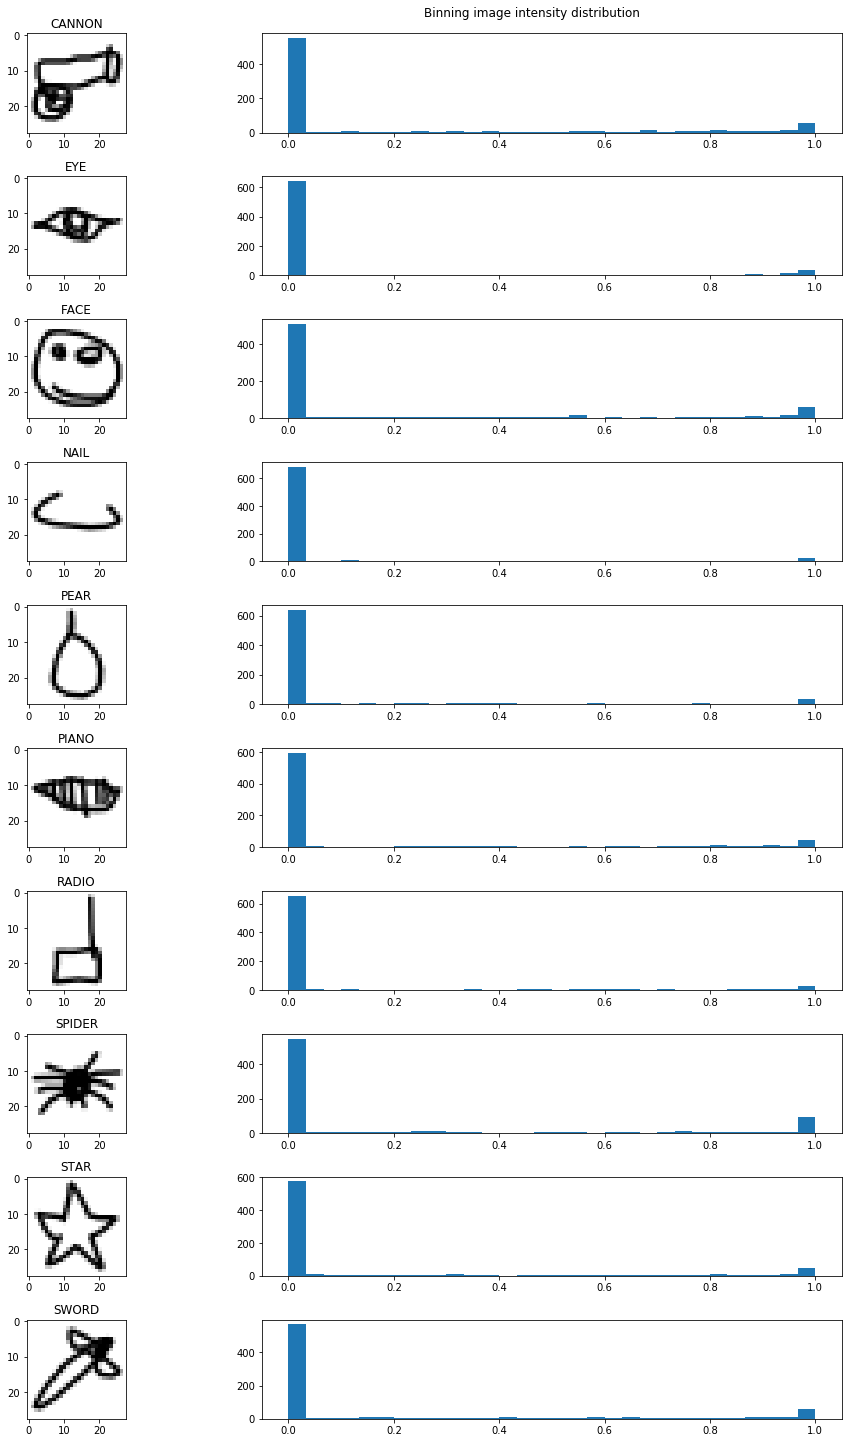

In [95]:
# Create Image Intensity Histrogram for each class
fig, axs = plt.subplots(10, 2, figsize=(15,20))
plt.suptitle('Binning image intensity distribution', x=.7,y=1)
for i, (key,value) in enumerate(classes_dict.items()):
    axs[i,0].set_title(key.upper())
    axs[i,0].imshow(value[0,:784].reshape((28,28)), cmap="gray_r")
    axs[i,1].hist(value[0,:784].reshape((28,28)).flatten(), bins=30,)
plt.tight_layout()

Most pixels in the dataset are completely white, along with another set of pixels that are completely dark, with relatively few in between. If we wanted to, we could probably replace each pixel with a binary 0 or 1 with very little loss of information.

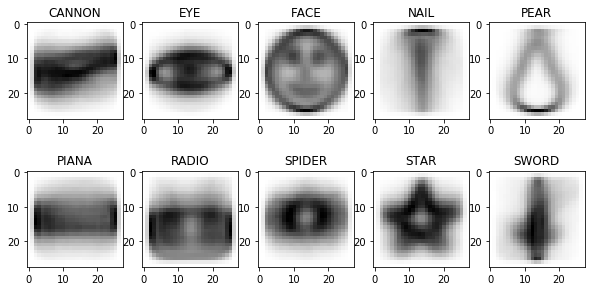

In [10]:
# Plot the average doodle for each class
plt.figure(figsize=(10,5))
for key, value in label_dict.items():
    lst = []
    for k in range(784):
        lst.append(np.mean(doodles[doodles[:,-1]==key,k]))
    plt.subplot(2,5,key+1)
    plt.imshow(np.array(lst).reshape((28,28)), cmap="gray_r")
    plt.title(value.upper())

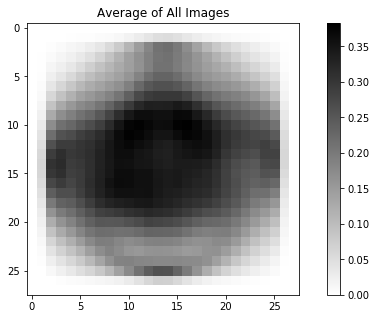

In [97]:
# Plot the average doodle for all images
plt.figure(figsize=(10,5))
for key, value in label_dict.items():
    lst = []
    for k in range(784):
        lst.append(np.mean(doodles[:,k]))
plt.imshow(np.array(lst).reshape((28,28)), cmap="gray_r")
plt.title('Average of All Images')
plt.colorbar()

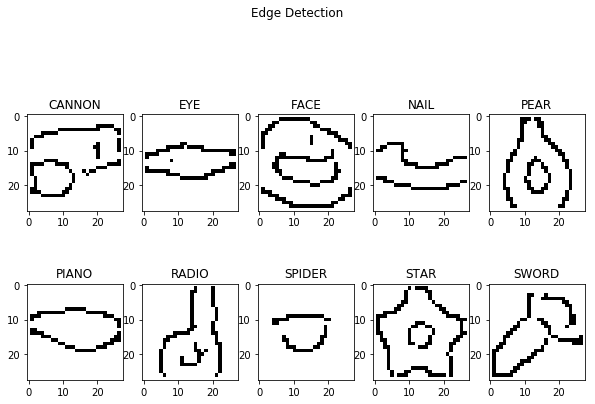

In [11]:
# Use the Canny filter which reduces the effect of noise present in the image and then
# potential edges are thinned down to 1-pixel curves by removing non-maximum pixels of the gradient magnitude

fig = plt.figure(figsize=(10,7))
edges = []
plt.suptitle('Edge Detection')
plt.subplots_adjust(hspace=-.2)
for i, (key,value) in enumerate(classes_dict.items()):
    ax = fig.add_subplot(2,5,i+1)
    edge = canny(value[0,:784].reshape((28,28)), sigma=3)
    plt.imshow(edge, cmap='binary')
    edges.append(edge)
    plt.title(key.upper())